# PostAnalysis for sequencing of Merfish oligo pool

by Pu Zheng

2023.11.21

In [9]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

877306


In [65]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import ImageAnalysis3 as ia3
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast
from ChromAn.src import file_io

from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

import pickle

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [11]:
data_folder = r'/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/'
analysis_folder = os.path.join(data_folder, 'Analysis')

# load probes

In [12]:
# Load probes:
from Bio import SeqIO

probe_filename = os.path.join(analysis_folder, 'All_probes.fasta')
print(probe_filename)

probes = []
for record in SeqIO.parse(probe_filename, "fasta"):
    probes.append(record)
print(len(probes))

/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/Analysis/All_probes.fasta
222042


In [13]:
probe_df = pd.DataFrame({
    'name':[ _pb.name for _pb in probes],
    'sequence': [str(_pb.seq) for _pb in probes],
})
probe_df

,name,sequence
0,MF1_Igkc_ENSMUST00000103410.3_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
1,MF1_Iglc2_ENSMUST00000103749.3_shift-0_GC-50.0...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
2,MF1_Il21_ENSMUST00000029273.8_shift-0_GC-56.6_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
3,MF1_Xcl1_ENSMUST00000027860.8_shift-0_GC-53.3_...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
4,MF1_S100a10_ENSMUST00000148400.2_shift-0_GC-56...,CCCGCAATGGCTGACAACCGGTCCTGTTCTTGTCGAGCGTGTCCTG...
...,...,...
222037,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGATGCTCCTGGCAGAGCACTGAGTGCT...
222038,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGAGAACGACACTGCTGCTTTCGGTAGA...
222039,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGACATTGCTTCACATACAGCTCAAATG...
222040,MO4_sequential_4326a528-01_Igfbp6__ENSMUST0000...,TAAGGTAGCTGTCGCCGCAGAAGACAGCCTCCGGCTTCTGTACAGC...


In [14]:
# load analysis 
sequence_folder = os.path.join(data_folder, '20231121_081440', 'Fastq')
alignment_stats = [os.path.join(sequence_folder, _f) for _f in os.listdir(sequence_folder) if '.idxstats' in _f]
alignment_stats

['/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MF2_S6_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MO4_S4_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-IntBC-30no_S5_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Amplified-MF3_S2_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/PCR-MF3_S1_L001.idxstats',
 '/lab/solexa_weissman/puzheng/Sequencing_data/231120_M01799_0478_000000000-KGY2N/20231121_081440/Fastq/Twist-MO4_S3_L001.idxstats']

## MO4

In [20]:
library_name = 'MO4'

lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

amplified_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'amplified' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_amplified_match_df = amplified_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_amplified_match_df = pd.concat([lib_amplified_match_df, lib_probe_df], axis=1)
len(lib_amplified_match_df), amplified_pool_stat['mapped'].sum(), amplified_pool_stat['unmapped'].sum()

(22734, 1963588, 5220)

In [21]:
np.mean(lib_amplified_match_df['mapped']), np.sum(lib_amplified_match_df['mapped']==0) / len(lib_amplified_match_df)

(86.2518694466438, 0.032066508313539195)

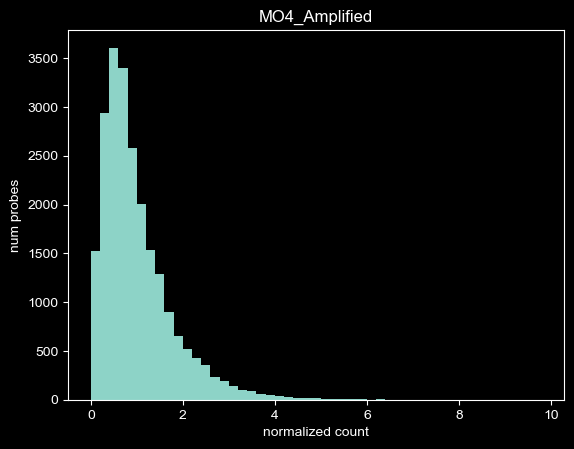

In [66]:
plt.figure()
plt.hist(lib_amplified_match_df['mapped'].values / np.mean(lib_amplified_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_Amplified")
plt.show()

In [45]:
lib_amplified_match_df['name'].values[0].split('_')[3]

'1700022I11Rik'

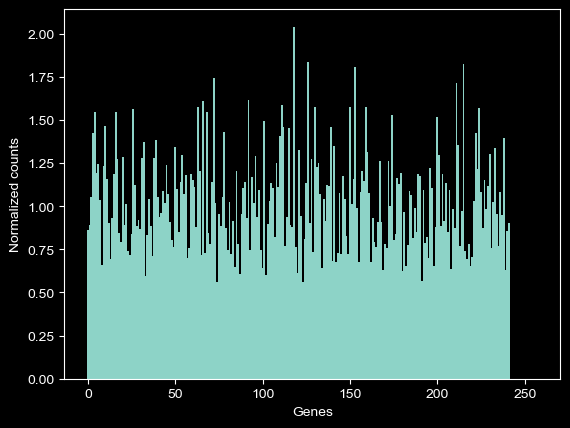

In [67]:
# split by gene
gene_2_amplified_match_df = {}
for _i, _row in lib_amplified_match_df.iterrows():
    _gene = _row['name'].split('_')[3]
    #print(_gene)
    if _gene not in gene_2_amplified_match_df:
        gene_2_amplified_match_df[_gene] = [_row['mapped']]
    else:
        gene_2_amplified_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_amplified_match_df['mapped'])/len(_v) for _v in gene_2_amplified_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

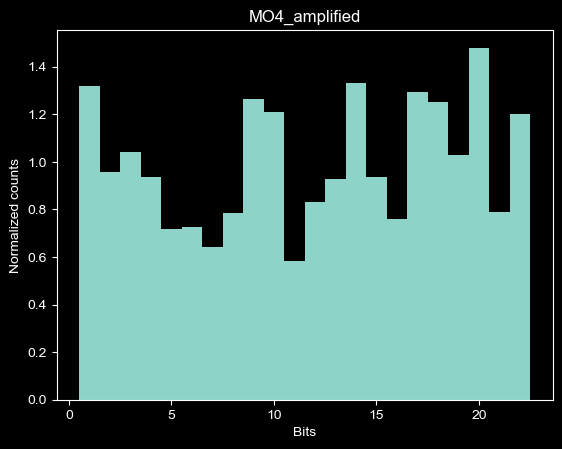

In [68]:
# split by probe
probe_2_amplified_matches = {}
for _i, _row in lib_amplified_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_amplified_matches:
        probe_2_amplified_matches[_probe] = [_row['mapped']]
    else:
        probe_2_amplified_matches[_probe].append(_row['mapped'])
#probes = [_k for _k in sorted(probe_2_amplified_matches.keys(), key=lambda v:int(v.split('_')[1]))]
#probe_total_counts = [np.sum(probe_2_amplified_matches[_p])/np.mean(lib_amplified_match_df['mapped'])/len(probe_2_amplified_matches[_p]) 
#                      for _p in probes]

import re
res = re.findall(r'(RS[0-9]+)', lib_amplified_match_df['name'].values[0])
readouts_2_amplified_pbs = {}
for _ir, _row in lib_amplified_match_df.iterrows():
    _ct = _row['mapped']
    _readouts = re.findall(r'(RS[0-9]+)', _row['name'])
    for _r in _readouts:
        if _r not in readouts_2_amplified_pbs:
            readouts_2_amplified_pbs[_r] = _ct
        else:
            readouts_2_amplified_pbs[_r] += _ct
            
probe_total_counts = [_v *22 / np.sum(list(readouts_2_amplified_pbs.values())) for _k,_v in sorted(readouts_2_amplified_pbs.items())][:22]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_amplified")
#for _gene, _counts in gene_2_amplified_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()

## MF3 PCR


In [69]:

lib_probe_df = probe_df.loc[
    np.array([library_name in _n for _n in probe_df['name']])
]

twist_pool_stat = pd.read_table([_f for _f in alignment_stats if library_name in _f and 'twist' in _f.lower()][0],
                                    header=None, names=['ref', 'length', 'mapped', 'unmapped'])
lib_twist_match_df = twist_pool_stat.loc[
    np.array([library_name in _n for _n in probe_df['name']]+[False])
]
lib_twist_match_df = pd.concat([lib_twist_match_df, lib_probe_df], axis=1)
len(lib_twist_match_df), twist_pool_stat['mapped'].sum(), twist_pool_stat['unmapped'].sum()

(22734, 1163126, 6066)

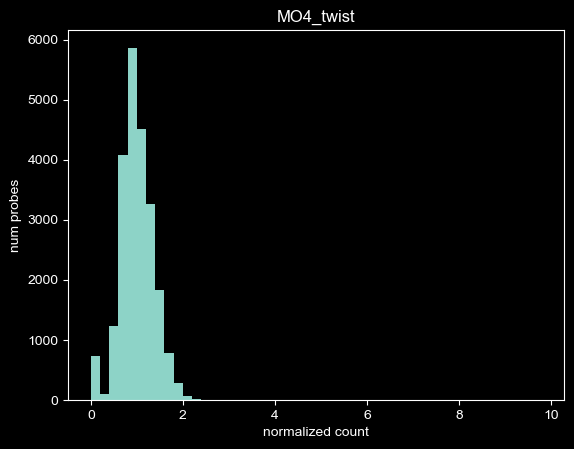

In [70]:
plt.figure()
plt.hist(lib_twist_match_df['mapped'].values / np.mean(lib_twist_match_df['mapped']), 
         bins=np.arange(0,10, 0.2))
plt.xlabel('normalized count')
plt.ylabel('num probes')
plt.title(f"{library_name}_twist")
plt.show()

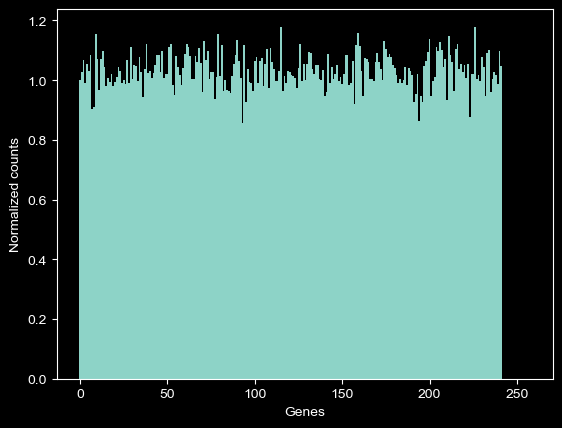

In [71]:
# split by gene
gene_2_twist_match_df = {}
for _i, _row in lib_twist_match_df.iterrows():
    _gene = _row['name'].split('_')[3]
    #print(_gene)
    if _gene not in gene_2_twist_match_df:
        gene_2_twist_match_df[_gene] = [_row['mapped']]
    else:
        gene_2_twist_match_df[_gene].append(_row['mapped'])
plt.figure()
gene_total_counts = [np.sum(_v)/np.mean(lib_twist_match_df['mapped'])/len(_v) for _v in gene_2_twist_match_df.values()]
plt.bar(np.arange(len(gene_total_counts)), gene_total_counts, width=1)
plt.xlabel('Genes')
plt.ylabel('Normalized counts')
#for _gene, _counts in gene_2_twist_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()
      

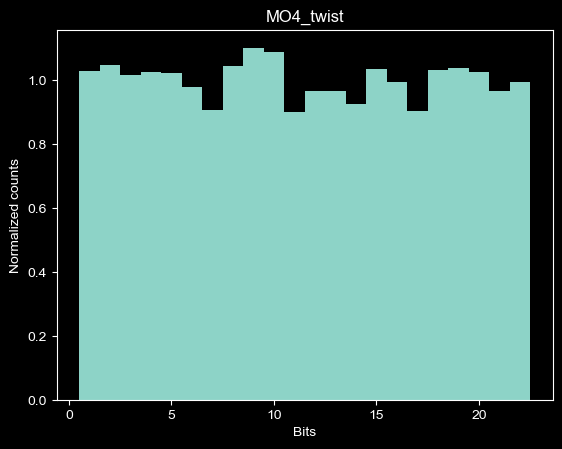

In [72]:
# split by probe
probe_2_twist_matches = {}
for _i, _row in lib_twist_match_df.iterrows():
    _probe = _row['name'].split('-')[-1]
    if _probe not in probe_2_twist_matches:
        probe_2_twist_matches[_probe] = [_row['mapped']]
    else:
        probe_2_twist_matches[_probe].append(_row['mapped'])
#probes = [_k for _k in sorted(probe_2_twist_matches.keys(), key=lambda v:int(v.split('_')[1]))]
#probe_total_counts = [np.sum(probe_2_twist_matches[_p])/np.mean(lib_twist_match_df['mapped'])/len(probe_2_twist_matches[_p]) 
#                      for _p in probes]

import re
res = re.findall(r'(RS[0-9]+)', lib_twist_match_df['name'].values[0])
readouts_2_twist_pbs = {}
for _ir, _row in lib_twist_match_df.iterrows():
    _ct = _row['mapped']
    _readouts = re.findall(r'(RS[0-9]+)', _row['name'])
    for _r in _readouts:
        if _r not in readouts_2_twist_pbs:
            readouts_2_twist_pbs[_r] = _ct
        else:
            readouts_2_twist_pbs[_r] += _ct
            
probe_total_counts = [_v *22 / np.sum(list(readouts_2_twist_pbs.values())) for _k,_v in sorted(readouts_2_twist_pbs.items())][:22]

plt.figure()
plt.bar(np.arange(len(probe_total_counts))+1, probe_total_counts, width=1)
plt.xlabel('Bits')
plt.ylabel('Normalized counts')
plt.title(f"{library_name}_twist")
#for _gene, _counts in gene_2_twist_matches.items():
#    plt.hist(_counts, bins=np.arange(0,100, 5), label=f"{_gene}")
plt.show()